In [1]:
# Importing core libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np

# For plotting graphs and setting a clean dark theme
import matplotlib.pyplot as plt
plt.style.use("dark_background")  # Apply dark background style for all plots

# For model performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For data normalization
from sklearn.preprocessing import MinMaxScaler

# Keras and TensorFlow imports for deep learning model creation
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Concatenate
from keras.optimizers import Adam

# Callback for stopping early if model stops improving
from keras.callbacks import EarlyStopping

# Suppress unnecessary warnings for a cleaner output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the TCS stock data from a CSV file
tcs = pd.read_csv("TCS.csv")

# Check the number of rows and columns in the dataset
tcs.shape

(4139, 15)

In [3]:
tcs.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2004-08-25,TCS,EQ,850.00,1198.7,1198.7,979.00,985.00,987.95,1008.32,17116372,1.725876e+15,NaN,5206360,0.3042
1,2004-08-26,TCS,EQ,987.95,992.0,997.0,975.30,976.85,979.00,985.65,5055400,4.982865e+14,NaN,1294899,0.2561
2,2004-08-27,TCS,EQ,979.00,982.4,982.4,958.55,961.20,962.65,969.94,3830750,3.715586e+14,NaN,976527,0.2549
3,2004-08-30,TCS,EQ,962.65,969.9,990.0,965.00,986.40,986.75,982.65,3058151,3.005106e+14,NaN,701664,0.2294
4,2004-08-31,TCS,EQ,986.75,986.5,990.0,976.00,987.80,988.10,982.18,2649332,2.602133e+14,NaN,695234,0.2624


In [4]:
# Display the first 5 rows of the dataset to get a quick look at the data
tcs.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2004-08-25,TCS,EQ,850.00,1198.7,1198.7,979.00,985.00,987.95,1008.32,17116372,1.725876e+15,NaN,5206360,0.3042
1,2004-08-26,TCS,EQ,987.95,992.0,997.0,975.30,976.85,979.00,985.65,5055400,4.982865e+14,NaN,1294899,0.2561
2,2004-08-27,TCS,EQ,979.00,982.4,982.4,958.55,961.20,962.65,969.94,3830750,3.715586e+14,NaN,976527,0.2549
3,2004-08-30,TCS,EQ,962.65,969.9,990.0,965.00,986.40,986.75,982.65,3058151,3.005106e+14,NaN,701664,0.2294
4,2004-08-31,TCS,EQ,986.75,986.5,990.0,976.00,987.80,988.10,982.18,2649332,2.602133e+14,NaN,695234,0.2624


In [5]:
# Convert the 'Date' column from string to datetime format for easier filtering and plotting
tcs['Date'] = pd.to_datetime(tcs['Date'])

# Create a boolean mask to filter data between Jan 2008 and Dec 2020
mask = (tcs['Date'] >= '2008-01-01') & (tcs['Date'] <= '2020-12-31')

# Apply the mask to get the filtered DataFrame
tcs_filtered = tcs.loc[mask]

In [6]:
# Keep only the relevant columns for analysis and modeling
tcs = tcs_filtered[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

In [7]:
# Set the 'Date' column as the index for time series operations
tcs.set_index('Date', inplace=True)

In [8]:
# Create the target variable: next day's closing price
tcs['close_t+1'] = tcs['Close'].shift(-1)

In [9]:
tcs

,Open,High,Low,Close,Volume,close_t+1
Date,,,,,,
2008-01-01,1077.00,1077.00,1052.00,1054.55,232097,1050.00
2008-01-02,1060.00,1061.00,1031.50,1050.00,716231,1011.05
2008-01-03,1030.10,1045.00,1005.35,1011.05,1292070,1005.20
2008-01-04,1011.05,1022.90,1002.30,1005.20,579717,975.60
2008-01-07,1000.00,1008.80,972.50,975.60,911836,987.85
...,...,...,...,...,...,...
2020-12-24,2909.00,2921.35,2883.20,2909.35,1807144,2929.40
2020-12-28,2910.00,2949.70,2902.00,2929.40,2108994,2930.50
2020-12-29,2920.00,2952.00,2920.00,2930.50,1994151,2909.30


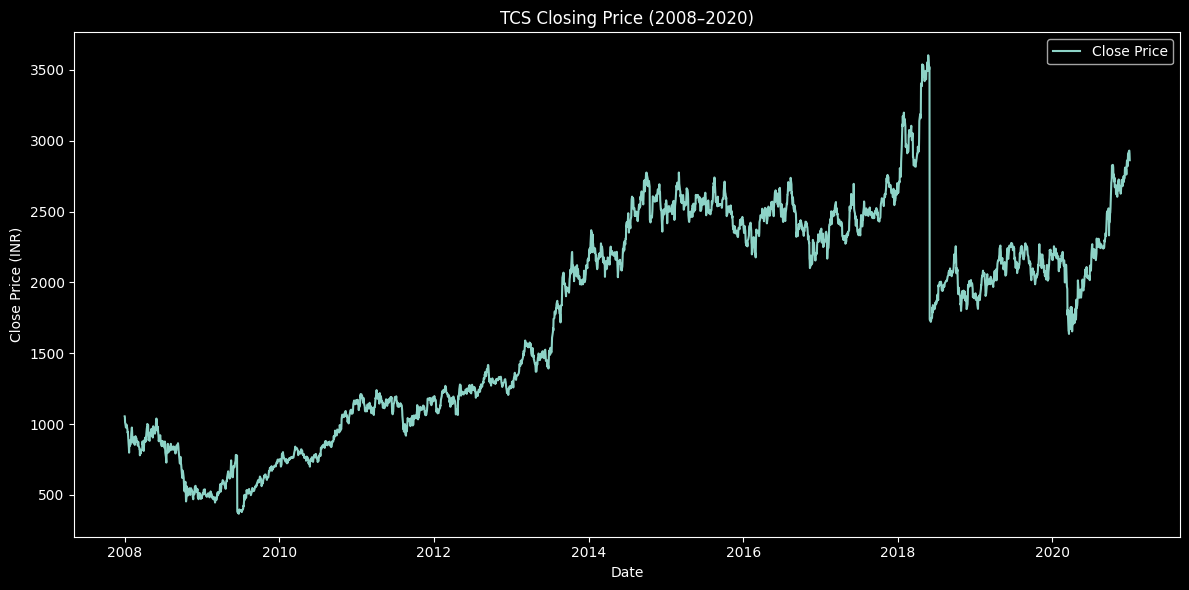

In [10]:
# Plot the closing price of TCS over time

plt.figure(figsize=(12, 6))                             # Set the figure size
plt.plot(tcs.index, tcs['Close'], label='Close Price')  # Line plot of closing prices over time

plt.title("TCS Closing Price (2008–2020)")              # Plot title
plt.xlabel("Date")                                      # X-axis label
plt.ylabel("Close Price (INR)")                         # Y-axis label
plt.legend()                                            # Show legend
plt.tight_layout()                                      # Adjust layout to prevent overlap
plt.show()                                              # Display the plot

In [11]:
# Define the feature columns to be used as input for the model
features = ['Open', 'High', 'Low', 'Close', 'Volume']

# Define the target column that the model will predict
target = 'close_t+1'

In [12]:
# Function to prepare hybrid inputs for the LSTM model
def prepare_hybrid_data(df, n_days):
    """
    Create two input sets:
    1. Past n days of close prices (LSTM input)
    2. Today's OHLCV features (Dense input)
    Target: close_t+1
    """
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    df = df.copy()
    
    # Initialize scalers for close prices and other features
    scaler_close = MinMaxScaler()
    scaler_features = MinMaxScaler()
    
    # Scale 'Close' separately for sequential input
    df['Close_scaled'] = scaler_close.fit_transform(df[['Close']])
    
    # Scale all feature columns for dense input
    df[features] = scaler_features.fit_transform(df[features])

    X_seq, X_static, y = [], [], []
    
    for i in range(n_days, len(df) - 1):
        # LSTM input: past n days of scaled 'Close' values
        seq_close = df['Close_scaled'].values[i - n_days:i].reshape(n_days, 1)
        
        # Dense input: today's scaled OHLCV features
        static_features = df[features].iloc[i].values
        
        # Target output: unscaled 'Close' of the next day
        target = df['Close'].iloc[i + 1]
        
        X_seq.append(seq_close)
        X_static.append(static_features)
        y.append(target)
    
    return np.array(X_seq), np.array(X_static), np.array(y).reshape(-1, 1), scaler_close

In [13]:
# Define the number of past days to consider for LSTM input
n_days = 3

# Prepare inputs for the hybrid model using the custom function
X_seq, X_static, y, scaler_close = prepare_hybrid_data(tcs, n_days)

# Print the shapes of each input and target array
print("LSTM Input (X_seq):", X_seq.shape)        # Shape: (samples, n_days, 1)
print("Dense Input (X_static):", X_static.shape) # Shape: (samples, 5)
print("Target (y):", y.shape)                    # Shape: (samples, 1)

LSTM Input (X_seq): (3215, 3, 1)
Dense Input (X_static): (3215, 5)
Target (y): (3215, 1)


In [14]:
# Split the dataset: 70% training, 15% validation, 15% testing
total_samples = len(X_seq)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)

# LSTM input splits
X_seq_train = X_seq[:train_size]
X_seq_val = X_seq[train_size:train_size + val_size]
X_seq_test = X_seq[train_size + val_size:]

# Dense input splits
X_static_train = X_static[:train_size]
X_static_val = X_static[train_size:train_size + val_size]
X_static_test = X_static[train_size + val_size:]

# Target splits
y_train = y[:train_size]
y_val = y[train_size:train_size + val_size]
y_test = y[train_size + val_size:]

In [15]:
print("Dataset Shapes (after splitting):\n")

print("\n LSTM Input:")
print("  X_seq_train:", X_seq_train.shape)
print("  X_seq_val:  ", X_seq_val.shape)
print("  X_seq_test: ", X_seq_test.shape)

print("\n Dense Input (OHLCV):")
print("  X_static_train:", X_static_train.shape)
print("  X_static_val:  ", X_static_val.shape)
print("  X_static_test: ", X_static_test.shape)

print("\n Target Output (Close_t+1):")
print("  y_train:", y_train.shape)
print("  y_val:  ", y_val.shape)
print("  y_test: ", y_test.shape)


Dataset Shapes (after splitting):


 LSTM Input:
  X_seq_train: (2250, 3, 1)
  X_seq_val:   (482, 3, 1)
  X_seq_test:  (483, 3, 1)

 Dense Input (OHLCV):
  X_static_train: (2250, 5)
  X_static_val:   (482, 5)
  X_static_test:  (483, 5)

 Target Output (Close_t+1):
  y_train: (2250, 1)
  y_val:   (482, 1)
  y_test:  (483, 1)


# Model Code

## Why This Hybrid LSTM + Dense Model?

This model combines two inputs to predict `Close_t+1` (next day's closing price):

---

### LSTM Branch – Past `n_days` of Close Prices

```python
input_seq = Input(shape=(n_days, 1))
lstm_out = LSTM(64)(input_seq)

In [16]:
# Branch 1: LSTM on past n days of 'Close'
input_seq = Input(shape=(n_days, 1))
lstm_out = LSTM(64)(input_seq)

# Branch 2: Dense on today’s OHLCV
input_static = Input(shape=(5,))
dense_out = Dense(32, activation='relu')(input_static)

# Combine both branches
merged = Concatenate()([lstm_out, dense_out])
dense1 = Dense(64, activation='relu')(merged)
output = Dense(1)(dense1)

model = Model(inputs=[input_seq, input_static], outputs=output)
model.compile(optimizer='adam', loss='mse')

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 3, 1)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 64)                │          16,896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 32)                │             192 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 96)                │               0 │ lstm[0][0], dense[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           6,208 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │              65 │ dense_1[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 23,361 (91.25 KB)

 Trainable params: 23,361 (91.25 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Define early stopping to prevent overfitting during training
early_stop = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=10,                 # Stop if no improvement for 10 consecutive epochs
    restore_best_weights=True,  # Restore the model weights from the epoch with the best val_loss
    verbose=1                   # Print messages when stopping
)

In [19]:
# Train
history = model.fit(
    [X_seq_train, X_static_train], y_train,
    validation_data=([X_seq_val, X_static_val], y_val),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0563 - val_loss: 8.8908e-04
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4002e-04 - val_loss: 8.6067e-04
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1509e-04 - val_loss: 8.5453e-04
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0290e-04 - val_loss: 8.5313e-04
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1358e-04 - val_loss: 8.4572e-04
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0416e-04 - val_loss: 8.7117e-04
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9794e-05 - val_loss: 8.3887e-04
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.8198e-05 - val_loss: 8.4307e-04
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2934e-04 - val_loss: 8.2899e-04
Epoch 10/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1413e-04 - val_loss: 8.3314e-04
Epoch 11/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1534e-04 - 

In [20]:
# Predict
y_pred = model.predict([X_seq_test, X_static_test])

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Evaluation on Test Set:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R² Score: {r2:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Evaluation on Test Set:
RMSE: 0.01
MAE:  0.01
R² Score: 0.9750


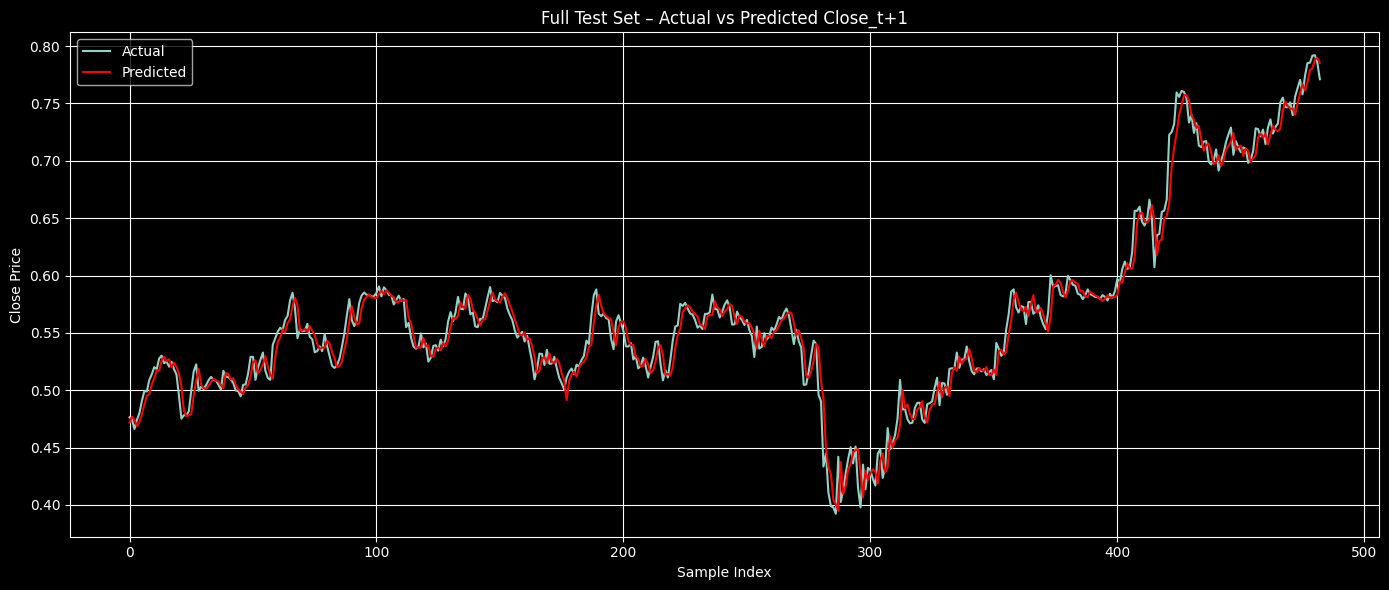

In [21]:
# Plot the actual vs predicted close prices for the test set
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual')                     # Actual close_t+1 prices
plt.plot(y_pred, label='Predicted', color='red')     # Predicted close_t+1 prices
plt.title("Full Test Set – Actual vs Predicted Close_t+1")
plt.xlabel("Sample Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()